In [1]:
import pandas as pd
import numpy as np
import csv

geco_train_english = pd.read_csv('../data/geco/train_test/train.tsv', sep='\t', encoding='utf8', quoting=csv.QUOTE_NONE)
geco_test_english = pd.read_csv('../data/geco/train_test/test.tsv', sep='\t', encoding='utf8', quoting=csv.QUOTE_NONE)

# geco_train_dutch = pd.read_csv('../data/geco/dutch/train.tsv', sep='\t', encoding='utf8')
# geco_test_dutch = pd.read_csv('../data/geco/dutch/test.tsv', sep='\t', encoding='utf8')

geco_train_english = geco_train_english[['participant', 'text_id', 'sentence_id', 'text', 'token_count', 'fix_count', 'fix_prob', 'mean_fix_dur', 'first_fix_dur', 'first_pass_dur', 'tot_fix_dur', 'refix_count', 'reread_prob', 'tot_regr_from_dur']]
geco_test_english = geco_test_english[['participant', 'text_id', 'sentence_id', 'text', 'token_count', 'fix_count', 'fix_prob', 'mean_fix_dur', 'first_fix_dur', 'first_pass_dur', 'tot_fix_dur', 'refix_count', 'reread_prob', 'tot_regr_from_dur']]

In [2]:
with open('../data/geco/preprocessed/preprocessed_geco_sentence_level.tsv',  'r', encoding='utf8') as infile:
    with open('../data/geco/sents.txt', 'w', encoding='utf8') as outfile:
        lines = infile.readlines()
        for i, line in enumerate(lines):
            if i > 0:
                elements = line.strip('\n').split('\t')
                sent = elements[3]
                outfile.write(sent + '\n')

Concatenate the linguistic features associated with the GECO sentences in English and Dutch:

In [3]:
en_geco_train_feats = pd.read_csv('../data/geco/ling_feats_train_data.csv', sep='\t')
en_geco_train_feats = en_geco_train_feats.drop('Filename', axis=1)
en_geco_train_feats.reset_index(drop=True)

en_train_cols =  geco_train_english.columns.to_list() + en_geco_train_feats.columns.to_list()
en_train_concatenation = np.concatenate([geco_train_english, en_geco_train_feats], axis=1)
en_geco_train_full = pd.DataFrame(en_train_concatenation, columns=en_train_cols)

In [4]:
# en_geco_test_feats = pd.read_csv('../data/geco/english/test_feats.csv', sep='\t')
# en_geco_test_feats = en_geco_test_feats.drop('Filename', axis=1)
# en_geco_test_feats.reset_index(drop=True)

# en_test_cols = geco_test_english.columns.to_list() + en_geco_test_feats.columns.to_list()
# en_test_concatenation = np.concatenate([geco_test_english, en_geco_test_feats], axis=1)
# en_geco_test_full = pd.DataFrame(en_test_concatenation, columns=en_test_cols)

In [5]:
# dutch_geco_train_feats = pd.read_csv('../data/geco/dutch/train_feats.csv', sep='\t')
# dutch_geco_train_feats = dutch_geco_train_feats.drop('Filename', axis=1)
# dutch_geco_train_feats.reset_index(drop=True)

# dutch_train_cols = geco_train_dutch.columns.to_list() + dutch_geco_train_feats.columns.to_list()
# dutch_train_concatenation = np.concatenate([geco_train_dutch, dutch_geco_train_feats], axis=1)
# dutch_geco_train_full = pd.DataFrame(dutch_train_concatenation, columns=dutch_train_cols)

In [6]:
# dutch_geco_test_feats = pd.read_csv('../data/geco/dutch/test_feats.csv', sep='\t')
# dutch_geco_test_feats = dutch_geco_test_feats.drop('Filename', axis=1)
# dutch_geco_test_feats.reset_index(drop=True)

# test_cols = geco_test_dutch.columns.to_list() + dutch_geco_test_feats.columns.to_list()
# test_concatenation = np.concatenate([geco_test_dutch, dutch_geco_test_feats], axis=1)
# dutch_geco_test_full = pd.DataFrame(test_concatenation, columns=test_cols)

Concatenate the train and test sets:

In [7]:
en_geco_train_full.reset_index(drop=True)
# en_geco_test_full.reset_index(drop=True)
# dutch_geco_train_full.reset_index(drop=True)
# dutch_geco_test_full.reset_index(drop=True)

# geco_english = pd.concat([en_geco_train_full, en_geco_test_full])
# geco_dutch = pd.concat([dutch_geco_train_full, dutch_geco_test_full])

# geco_train_english.reset_index(drop=True)
# geco_test_english.reset_index(drop=True)

geco_english = en_geco_train_full

Add frequencies to dataframes:

In [8]:
from wordfreq import zipf_frequency
import numpy as np
import string

# Map to look up languages in the wordfreq package
language_map = {'Dutch': 'nl',
                'English': 'en',
                'Finnish': 'fi',
                'German': 'de',
                'Greek': 'el',
                'Hebrew': 'he',
                'Korean': 'ko',
                'Norwegian': 'nb',
                'Russian': 'ru',
                'Spanish': 'es',
                'Turkish': 'tr',
                'Korean': 'ko',
                'Italian': 'it'}

def get_avg_token_freq(sentences, language):

    avg_token_freqs = []
    
    for sentence in sentences:
        
        # remove punctuation
        clean_sentence = sentence.translate(str.maketrans('', '', string.punctuation))

        # split sentence based on spaces
        tokens = clean_sentence.split(' ')
        
        # get zipf frequency of each token
        freqs = []
        for token in tokens:
            freq = zipf_frequency(token, language_map[language], wordlist='best', minimum=1.0)
            freqs.append(freq)
        
        # calculate average token frequency in the sentence
        avg_token_freqs.append(np.mean(freqs))

    return avg_token_freqs

def get_n_low_freq_words(sentences, language, threshold=4):

    num_low_freq_words_per_sent = []

    for sentence in sentences:
        
        num_low_freq_words = 0
        
        # remove punctuation
        clean_sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        
        # split sentence based on spaces
        tokens = clean_sentence.split(' ')
        
        # get zipf frequency of each token
        for token in tokens:
            freq = zipf_frequency(token, language_map[language], wordlist='best', minimum=1.0)

            # check if the frequency is below the treshold --> if so, count it as low-frequency
            if freq < threshold:
                num_low_freq_words += 1
            else:
                # if the word is not in the dictionary, continue
                continue
                
        num_low_freq_words_per_sent.append(num_low_freq_words)

    return num_low_freq_words_per_sent

def get_avg_word_length_with_punct(sentences):

    avg_word_lengths = []
    
    for sentence in sentences:
        
        # split sentence based on spaces
        words = sentence.split(' ')
        
        # get word lengths
        word_lengths = [len(word) for word in words]
        
        # calculate average word length in the sentence
        avg_word_lengths.append(np.mean(word_lengths))
        
    return avg_word_lengths

In [9]:
geco_english['avg_token_freq'] = get_avg_token_freq(geco_english['text'].tolist(), 'English')
geco_english['n_low_freq_words'] = get_n_low_freq_words(geco_english['text'].tolist(), 'English')
geco_english['avg_word_length'] = get_avg_word_length_with_punct(geco_english['text'].tolist())

# geco_dutch['avg_token_freq'] = get_avg_token_freq(geco_dutch['text'].tolist(), 'Dutch')
# geco_dutch['n_low_freq_words'] = get_n_low_freq_words(geco_dutch['text'].tolist(), 'Dutch')
# geco_dutch['avg_word_length'] = get_avg_word_length_with_punct(geco_dutch['text'].tolist())

Scale eye-tracking features to fall in the range 0-100:

In [10]:
from sklearn.preprocessing import MinMaxScaler

def scale(feature_values):

    scaler = MinMaxScaler(feature_range=(0,100))

    # reshape 1D array to 2D
    reshaped_feature_list = np.array(feature_values).reshape(-1, 1)

    # scale feature values between 0 and 100
    scaled_feature_values = scaler.fit_transform(reshaped_feature_list)

    # flatten the 2D array to 1D
    flat_scaled_feature_values = np.ravel(scaled_feature_values)

    return flat_scaled_feature_values

def inverse_transform(true_values, predicted_values):
    
    scaler = MinMaxScaler(feature_range=(0,100))

    # reshape 1D array to 2D
    reshaped_feature_list = np.array(true_values).reshape(-1, 1)

    # scale feature values between 0 and 100
    scaled_feature_values = scaler.fit_transform(reshaped_feature_list)

    # flatten the 2D array to 1D
    flat_scaled_feature_values = np.ravel(scaled_feature_values)
    
    # inverse transform
    inversed_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1,1))
    
    # flatten the 2D array to 1D
    flat_inversed_values = np.ravel(inversed_values)
    
    return flat_inversed_values

def add_scaled_columns(df):
    
    df['scaled_fpd'] = scale(df['first_pass_dur'].tolist())
    df['scaled_fxc'] = scale(df['fix_count'].tolist())
    df['scaled_tfd'] = scale(df['tot_fix_dur'].tolist())
    df['scaled_rd'] = scale(df['tot_regr_from_dur'].tolist())
    
    return df

In [11]:
#add columns with predictions

def add_preds(df, language):

    fpd_preds=[]
    fxc_preds=[]
    tfd_preds=[]
    rd_preds=[]

    with open(f'../results/eye-movement-prediction/preds_normal/preds_eval-meco-{language}_4.tsv', 'r') as infile:
        lines = infile.readlines()
        for line in lines:
            items = line.split('\t')
            task = items[0]
            pred = float(items[1].lstrip('[').rstrip(']'))
            label = items[2]
            if task == 'scaled_first_pass_dur':
                fpd_preds.append(pred)
            elif task == 'scaled_fix_count':
                fxc_preds.append(pred)
            elif task == 'scaled_tot_fix_dur':
                tfd_preds.append(pred)
            elif task == 'scaled_tot_regr_from_dur':
                rd_preds.append(pred)

#     df['fpd_pred'] = inverse_transform(df['first_pass_dur'], fpd_preds)
#     df['fxc_pred'] = inverse_transform(df['fix_count'], fxc_preds)
#     df['tfd_pred'] = inverse_transform(df['tot_fix_dur'], tfd_preds)
#     df['rd_pred'] = inverse_transform(df['tot_regr_from_dur'], rd_preds)

    df['fpd_pred'] = fpd_preds
    df['fxc_pred'] = fxc_preds
    df['tfd_pred'] = tfd_preds
    df['rd_pred'] = rd_preds
    
    return df

def add_preds_scrambled(df, language):

    fpd_preds=[]
    fxc_preds=[]
    tfd_preds=[]
    rd_preds=[]

    with open(f'../results/eye-movement-prediction/preds_scrambled/preds_eval-meco-scrambled-{language}_4.tsv', 'r') as infile:
        lines = infile.readlines()
        for line in lines:
            items = line.split('\t')
            task = items[0]
            pred = float(items[1].lstrip('[').rstrip(']'))
            label = items[2]
            if task == 'scaled_first_pass_dur':
                fpd_preds.append(pred)
            elif task == 'scaled_fix_count':
                fxc_preds.append(pred)
            elif task == 'scaled_tot_fix_dur':
                tfd_preds.append(pred)
            elif task == 'scaled_tot_regr_from_dur':
                rd_preds.append(pred)

#     df['fpd_pred'] = inverse_transform(df['first_pass_dur'], fpd_preds)
#     df['fxc_pred'] = inverse_transform(df['fix_count'], fxc_preds)
#     df['tfd_pred'] = inverse_transform(df['tot_fix_dur'], tfd_preds)
#     df['rd_pred'] = inverse_transform(df['tot_regr_from_dur'], rd_preds)

    df['fpd_pred_scrambled'] = fpd_preds
    df['fxc_pred_scrambled'] = fxc_preds
    df['tfd_pred_scrambled'] = tfd_preds
    df['rd_pred_scrambled'] = rd_preds
    
    return df


In [12]:
import sklearn.metrics as metrics

def mean_baseline(df_train, df_test, target_label):

    # Get the true values of the target eye-tracking feature (scaled between 0-100)
    y_true_test = scale(df_test[target_label].tolist())
    y_true_train = scale(df_train[target_label].tolist())

    # Use the mean as the predicted value every time
    y_pred = len(y_true_test) * [np.mean(y_true_train)]
#     print('true values test', y_true_test[:10])
#     print('true values train', y_true_train[:10])
#     print('mean baseline', y_pred[:10])

    # Evaluate
    mae = metrics.mean_absolute_error(y_true_test, y_pred)
    mse = metrics.mean_squared_error(y_true_test, y_pred)
    rmse = np.sqrt(mse)  # or mse**(0.5)
    r2 = metrics.r2_score(y_true_test, y_pred)

    results = {'target': target_label,
               'baseline_model': 'mean',
               'mae': mae,
               'accuracy': (100 - mae),
               'r2': r2,
               'mse': mse,
               'rmse': rmse}

    return results

geco_train_scaled = add_scaled_columns(geco_train_english)
geco_test_scaled = add_scaled_columns(geco_test_english)

for metric in ['scaled_fpd', 'scaled_tfd', 'scaled_fxc', 'scaled_rd']:
    print(mean_baseline(geco_train_scaled, geco_test_scaled, metric))

# dutch_geco_train_scaled = add_scaled_columns(dutch_geco_train_full)
# dutch_geco_test_scaled = add_scaled_columns(dutch_geco_test_full)

{'target': 'scaled_fpd', 'baseline_model': 'mean', 'mae': 13.475329881293042, 'accuracy': 86.52467011870695, 'r2': -0.002467402949719588, 'mse': 304.53085573061827, 'rmse': 17.450812466203924}
{'target': 'scaled_tfd', 'baseline_model': 'mean', 'mae': 13.552931513282445, 'accuracy': 86.44706848671755, 'r2': -0.0018924300883760292, 'mse': 322.1258039683549, 'rmse': 17.94786349313909}
{'target': 'scaled_fxc', 'baseline_model': 'mean', 'mae': 13.50821673816244, 'accuracy': 86.49178326183755, 'r2': -0.0027632638472772086, 'mse': 317.9050683802484, 'rmse': 17.82989255100121}
{'target': 'scaled_rd', 'baseline_model': 'mean', 'mae': 11.420848150347059, 'accuracy': 88.57915184965294, 'r2': -0.18714238638706115, 'mse': 297.2211805615295, 'rmse': 17.240103844279172}


In [13]:
# en_geco_train_scaled.to_csv('data/geco/english/train_scaled_and_correct_feats.tsv', sep='\t', encoding='utf8',quoting=csv.QUOTE_NONE)
# en_geco_test_scaled.to_csv('data/geco/english/test_scaled_and_correct_feats.tsv', sep='\t', encoding='utf8',quoting=csv.QUOTE_NONE)

# dutch_geco_train_scaled.to_csv('data/geco/dutch/train_scaled_and_correct_feats.tsv', sep='\t', encoding='utf8',quoting=csv.QUOTE_NONE)
# dutch_geco_test_scaled.to_csv('data/geco/dutch/test_scaled_and_correct_feats.tsv', sep='\t', encoding='utf8',quoting=csv.QUOTE_NONE)

In [13]:
#geco_dutch = add_scaled_columns(geco_dutch)
geco_english = add_scaled_columns(geco_english)

Combine the MECO languages into a single dataframe:

In [24]:
import os
import pandas as pd

def get_meco_df(language):
    
    path = f'../data/meco/files_per_language/{language}/test.tsv'
    
    if os.path.exists(path):
        df = pd.read_csv(f'../data/meco/files_per_language/{language}/test.tsv', sep='\t', encoding='utf8')
        df['dataset'] = len(df) * [f'{language}']
        
        #add frequency information
        if language != 'Estonian' and language != 'Korean':
            df['avg_token_freq'] = get_avg_token_freq(df['text'], language)
            df['n_low_freq_words'] = get_n_low_freq_words(df['text'], language)
            df['avg_word_length'] = get_avg_word_length_with_punct(df['text'].tolist())

        df = add_scaled_columns(df)
        df = df.rename(columns={'sent.nwords': 'token_count'})
        df = add_preds(df, language)
#         df = add_preds_scrambled(df, language)
#         df = add_preds_permuted(df, language)
    
    return df

In [15]:
meco_english = get_meco_df('English')
#meco_english['fpd_pred_scrambled']
meco_english

,lang,trialid,sentnum,text,token_count,blink,skip,nrun,reread,fix_count,...,scaled_n_low_freq_words,dataset,scaled_fpd,scaled_fxc,scaled_tfd,scaled_rd,fpd_pred,fxc_pred,tfd_pred,rd_pred
0,en,1,1,"In ancient Roman religion and myth, Janus is t...",14.000000,0.736842,0.0,2.105263,0.605263,25.736842,...,25.0,English,39.674190,35.765906,38.531011,0.000000,40.905598,40.413100,42.963680,13.546892
1,en,1,2,He has a double nature and is usually depicted...,23.000000,0.710526,0.0,2.473684,0.710526,27.815789,...,12.5,English,23.825183,41.099337,42.628949,8.750732,54.002045,51.240140,53.237656,20.650589
2,en,1,3,Janus presided over the beginning and ending o...,14.000000,0.763158,0.0,2.578947,0.684211,20.552632,...,25.0,English,10.211227,22.466083,24.345367,34.108736,36.772793,35.868860,36.584538,15.068628
3,en,1,4,The doors of his temple were open in times of ...,15.000000,0.684211,0.0,2.052632,0.578947,17.631579,...,12.5,English,12.266836,14.972274,16.195266,10.916295,41.481590,39.947630,41.025185,20.084934
4,en,1,5,"As the god of gates, he was also associated wi...",17.342105,0.763158,0.0,2.315789,0.631579,20.710526,...,25.0,English,16.640141,22.871154,24.788092,34.912711,39.287250,36.625404,38.837578,14.974799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,en,12,4,The registration identifier is a series of let...,22.000000,0.742857,0.0,2.257143,0.657143,27.000000,...,62.5,English,32.742208,39.006472,44.942431,15.171736,67.838330,69.649635,73.935090,32.175140
95,en,12,5,"In some countries, the identifier is unique wi...",22.000000,0.657143,0.0,1.885714,0.428571,20.885714,...,12.5,English,25.388460,23.320589,23.499085,8.758634,59.641605,57.535460,59.922215,25.337265
96,en,12,6,France was the first country to introduce the ...,15.000000,0.542857,0.0,1.714286,0.428571,14.257143,...,12.5,English,10.271485,6.315334,4.857067,14.000854,41.728348,39.030460,40.595417,13.116323
97,en,12,7,Early twentieth century plates varied in size ...,36.000000,0.685714,0.0,1.657143,0.342857,30.200000,...,37.5,English,64.919939,47.215906,48.029344,1.747281,97.365974,103.541050,107.254910,54.010174


Plot features:

<Figure size 432x288 with 0 Axes>

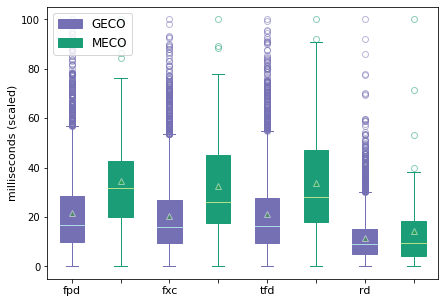

In [34]:
fig = plt.figure()
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

et_metrics = ['fpd', 'fxc', 'tfd', 'rd']

results_list=[]
labels=[]
for metric in et_metrics:
    results_list.append(geco_english[f'scaled_{metric}'].tolist())
    results_list.append(meco_english[f'scaled_{metric}'].tolist())
    labels.extend([metric, ''])

# rectangular box plot
bplot1 = ax1.boxplot(results_list,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                     showfliers=True,
                     showmeans=True)  # will be used to label x-ticks

# fill with colors
colors = ['#7570b3', '#1b9e77'] * len(et_metrics)
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    
for patch, color in zip(bplot1['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_alpha(0.5)
    
for patch, color in zip(bplot1['means'], colors):
    patch.set_markeredgecolor('white')
    patch.set_alpha(0.5)
    
colors = ['lightblue', '#b2df8a'] * len(et_metrics)
for patch, color in zip(bplot1['medians'], colors):
     patch.set_color(color)
        
colors = ['#7570b3', '#7570b3', '#1b9e77', '#1b9e77'] * len(et_metrics)
for patch, color in zip(bplot1['whiskers'], colors):
    patch.set_color(color)

for patch, color in zip(bplot1['caps'], colors):
    patch.set_color(color)
    
plt.xticks(list(range(1, 9)), fontsize=11, horizontalalignment='center')
plt.ylabel("milliseconds (scaled)", fontsize=11)
plt.legend([bplot1["boxes"][0], bplot1["boxes"][1]], ['GECO', 'MECO'], loc='upper left', prop={'size': 12})

ModuleNotFoundError: No module named 'MeCab'

<Figure size 432x288 with 0 Axes>

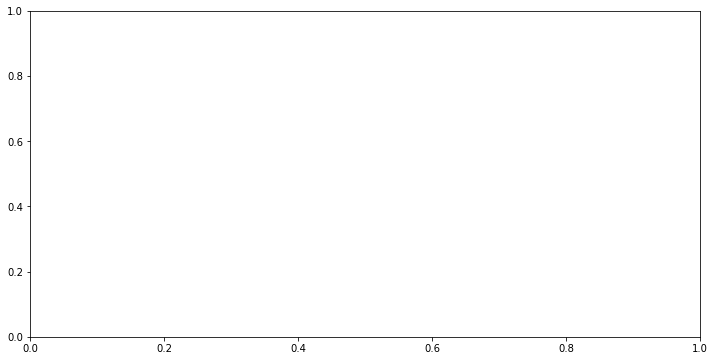

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

languages = ['English', 'Dutch', 'German', 'Finnish', 'Norwegian', 'Estonian', 'Spanish', 'Italian', 'Greek', 'Russian', 'Hebrew', 'Turkish', 'Korean']

#tfd_list = [geco_dutch['tot_fix_dur'].tolist(), geco_english['tot_fix_dur'].tolist()]
tfd_list = [geco_english['tot_fix_dur'].tolist()]
for lang in languages:
    df = get_meco_df(lang)
    tfd_list.append(df['tot_fix_dur'].tolist())

    
labels = ['English', 'English', 'Dutch', 'German', 'Finnish', 'Norwegian', 'Estonian', 'Spanish',  'Italian', 'Greek', 'Russian', 'Hebrew', 'Turkish', 'Korean']

# rectangular box plot
bplot1 = ax1.boxplot(tfd_list,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                     showfliers=True)  # will be used to label x-ticks

# fill with colors
colors = ['#7570b3'] + ['#1b9e77'] * len(languages) * 2
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    
for patch, color in zip(bplot1['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_alpha(0.5)
    
colors = ['lightblue'] + ['#b2df8a'] * len(languages) * 2
for patch, color in zip(bplot1['medians'], colors):
     patch.set_color(color)
        
colors = ['#7570b3', '#7570b3'] + ['#1b9e77'] * len(languages) * 2
for patch, color in zip(bplot1['whiskers'], colors):
    patch.set_color(color)

for patch, color in zip(bplot1['caps'], colors):
    patch.set_color(color)
    
plt.xticks(rotation=40)
plt.ylabel("total fixation duration (milliseconds)")
plt.legend([bplot1["boxes"][0], bplot1["boxes"][2]], ['GECO', 'MECO'], loc='upper right', prop={'size': 11})
        
plt.savefig('tfd-distribution-all.pdf', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

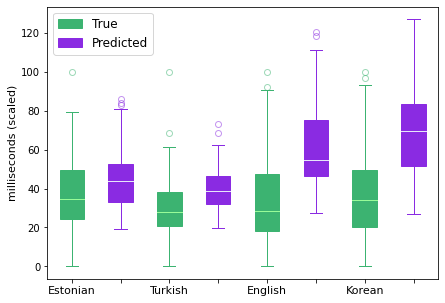

In [96]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

languages = ['Estonian', 'Turkish', 'English', 'Korean']

tfd_list=[]
labels=[]
for language in languages:
    df = get_meco_df(language)
    tfd_list.append(df['scaled_tot_fix_dur'].tolist())
    tfd_list.append(df['tfd_pred'].tolist())
    labels.extend([language, ''])

# rectangular box plot
bplot1 = ax1.boxplot(tfd_list,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                     showfliers=True)  # will be used to label x-ticks

# fill with colors
colors = ['mediumseagreen', 'blueviolet'] * len(languages)
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    
for patch, color in zip(bplot1['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_alpha(0.5)
    
colors = ['palegreen', 'lavender'] * len(languages)
for patch, color in zip(bplot1['medians'], colors):
     patch.set_color(color)
        
colors = ['mediumseagreen', 'mediumseagreen', 'blueviolet', 'blueviolet'] * len(languages)
for patch, color in zip(bplot1['whiskers'], colors):
    patch.set_color(color)

for patch, color in zip(bplot1['caps'], colors):
    patch.set_color(color)
    
plt.xticks(list(range(1, 9)), fontsize=11, horizontalalignment='center')
plt.ylabel("milliseconds (scaled)", fontsize=11)
plt.legend([bplot1["boxes"][0], bplot1["boxes"][1]], ['True', 'Predicted'], loc='upper left', prop={'size': 12})
#plt.title('Total Fixation Duration', fontsize=14)

plt.savefig('tfd-true-vs-pred.pdf', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

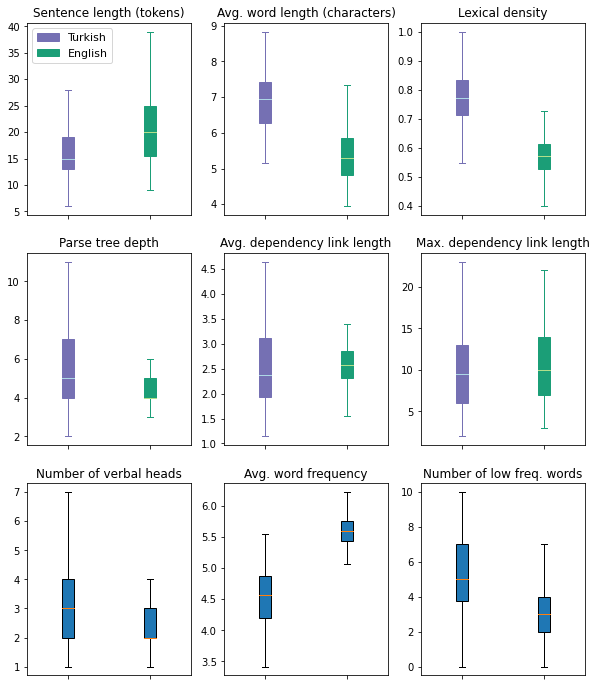

In [37]:
# import matplotlib.pyplot as plt

# fig = plt.figure()

# fig, ((ax1, ax2, ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(10,12))


# dataset_1 = get_meco_df('Turkish')
# dataset_2 = get_meco_df('English')

# # rectangular box plot
# bplot1 = ax1.boxplot([dataset_1['token_count'].tolist(), dataset_2['token_count'].tolist()],
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=['',''],
#                      showfliers=False)
# ax1.set_title('Sentence length (tokens)')

# bplot2 = ax2.boxplot([dataset_1['avg_word_length'].tolist(), dataset_2['avg_word_length'].tolist()],
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=['',''],
#                      showfliers=False) 
# ax2.set_title('Avg. word length (characters)')

# bplot3 = ax3.boxplot([dataset_1['lexical_density'].tolist(), dataset_2['lexical_density'].tolist()],
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=['',''],
#                      showfliers=False)  # will be used to label x-ticks
# ax3.set_title('Lexical density')

# bplot4 = ax4.boxplot([dataset_1['avg_max_depth'].tolist(), dataset_2['avg_max_depth'].tolist()],
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=['',''],
#                      showfliers=False)  # will be used to label x-ticks
# ax4.set_title('Parse tree depth')

# bplot5 = ax5.boxplot([dataset_1['avg_links_len'].tolist(), dataset_2['avg_links_len'].tolist()],
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=['',''],
#                      showfliers=False)  # will be used to label x-ticks
# ax5.set_title('Avg. dependency link length')


# bplot6 = ax6.boxplot([dataset_1['max_links_len'].tolist(), dataset_2['max_links_len'].tolist()],
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=['',''],
#                      showfliers=False)  # will be used to label x-ticks
# ax6.set_title('Max. dependency link length')

# bplot7 = ax7.boxplot([dataset_1['verbal_head_per_sent'].tolist(), dataset_2['verbal_head_per_sent'].tolist()],
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=['',''],
#                      showfliers=False)  # will be used to label x-ticks
# ax7.set_title('Number of verbal heads')

# bplot8 = ax8.boxplot([dataset_1['avg_token_freq'].tolist(), dataset_2['avg_token_freq'].tolist()],
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=['',''],
#                      showfliers=False)  # will be used to label x-ticks
# ax8.set_title('Avg. word frequency')

# bplot9 = ax9.boxplot([dataset_1['n_low_freq_words'].tolist(), dataset_2['n_low_freq_words'].tolist()],
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=['',''],
#                      showfliers=False)  # will be used to label x-ticks
# ax9.set_title('Number of low freq. words')

# # fill with colors
# colors = ['#7570b3', '#1b9e77']
# # for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
# for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6):
#     for patch, color in zip(bplot['boxes'], colors):
#         patch.set_facecolor(color)
#         patch.set_edgecolor(color)

# # for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
# for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6):
#     for patch, color in zip(bplot['fliers'], colors):
#         patch.set_markeredgecolor(color)
#         patch.set_alpha(0.5)
        
# colors = ['lightblue', '#b2df8a']
# #for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
# for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6):
#     for patch, color in zip(bplot['medians'], colors):
#         patch.set_color(color)
        
# colors = ['#7570b3', '#7570b3', '#1b9e77', '#1b9e77']
# #for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
# for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6):
#     for patch, color in zip(bplot['whiskers'], colors):
#         patch.set_color(color)

# #for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
# for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6):
#     for patch, color in zip(bplot['caps'], colors):
#         patch.set_color(color)
        
# ax1.legend([bplot1["boxes"][0], bplot1["boxes"][1]], ['Turkish', 'English'], loc='upper left', prop={'size': 11})
        
# #plt.savefig('plots/ling-complexity-geco-meco.pdf', dpi=300, bbox_inches='tight')

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [68]:
target_feats = ['scaled_fpd', 'scaled_fxc', 'scaled_tfd', 'scaled_rd',
                'fpd_pred', 'fxc_pred', 'tfd_pred', 'rd_pred',
                'token_count', 'avg_word_length',             
                'lexical_density',                                                  
                'avg_max_depth', 'avg_links_len', 'max_links_len', 'verbal_head_per_sent', 
                'avg_token_freq', 'n_low_freq_words']                                    

name_mapping = {'scaled_fpd': 'first-pass duration',
                'scaled_fxc': 'fixation count',
                'scaled_tfd': 'total fixation duration',
                'scaled_rd': 'regression duration',
                 'fpd_pred': 'first-pass duration (pred)',
                 'fxc_pred': 'fixation count (pred)',
                 'tfd_pred': 'total fixation duration (pred)',
                 'rd_pred': 'regression duration (pred)',
                'token_count': 'sentence length (tokens)',
                'avg_word_length': 'avg. word length (characters)',
                'lexical_density': 'lexical density',
                'avg_max_depth': 'parse tree depth',
                'avg_links_len': 'avg. dependency link length',
                'max_links_len': 'max. dependency link length',
                'verbal_head_per_sent': 'number of verbal heads',
                'avg_token_freq': 'avg. word frequency',
                'n_low_freq_words': 'number of low frequency words'}

for f in target_feats:
    meco_english = meco_english.rename(columns={f'{f}': name_mapping[f]})

In [69]:
geco_english.columns

Index(['participant', 'text_id', 'sentence_id', 'text', 'token_count',
       'fix_count', 'fix_prob', 'mean_fix_dur', 'first_fix_dur',
       'first_pass_dur',
       ...
       'subordinate_dist_3', 'subordinate_dist_4', 'subordinate_dist_5',
       'avg_token_freq', 'n_low_freq_words', 'avg_word_length', 'scaled_fpd',
       'scaled_fxc', 'scaled_tfd', 'scaled_rd'],
      dtype='object', length=144)

In [70]:
target_feats = ['scaled_fpd', 'scaled_fxc', 'scaled_tfd', 'scaled_rd',
                'token_count', 'avg_word_length',             
                'lexical_density',                                                  
                'avg_max_depth', 'avg_links_len', 'max_links_len', 'verbal_head_per_sent', 
                'avg_token_freq', 'n_low_freq_words']                                    

name_mapping = {'scaled_fpd': 'first-pass duration',
                'scaled_fxc': 'fixation count',
                'scaled_tfd': 'total fixation duration',
                'scaled_rd': 'regression duration',
                'token_count': 'sentence length (tokens)',
                'avg_word_length': 'avg. word length (characters)',
                'lexical_density': 'lexical density',
                'avg_max_depth': 'parse tree depth',
                'avg_links_len': 'avg. dependency link length',
                'max_links_len': 'max. dependency link length',
                'verbal_head_per_sent': 'number of verbal heads',
                'avg_token_freq': 'avg. word frequency',
                'n_low_freq_words': 'number of low frequency words'}

for f in target_feats:
    geco_english[f] = pd.to_numeric(geco_english[f], downcast="float")
    geco_english = geco_english.rename(columns={f'{f}': name_mapping[f]})

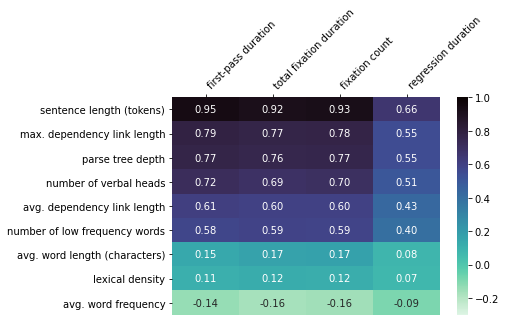

In [71]:
geco_corr = geco_english[name_mapping.values()].corr(method='spearman')
geco_corr = geco_corr.drop(['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration'], axis=0)
geco_corr = geco_corr[['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']].sort_values(by=['first-pass duration'],ascending=False)

heatmap = sns.heatmap(geco_corr,
            vmax=1,
            vmin=-0.3,
            cmap='mako_r',
            annot=True,
            linewidths=0,
            linecolor='white',
                     fmt='.2f')

x_axis_labels = ['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']
heatmap.set_xticklabels(x_axis_labels, rotation=45, horizontalalignment='left')

heatmap.xaxis.tick_top() # x axis on top
heatmap.xaxis.set_label_position('top')

#plt.savefig('plots/geco-heatmap.pdf', dpi=300, bbox_inches='tight')

In [72]:
import seaborn as sns

order = ['sentence length (tokens)',
         'max. dependency link length',
         'parse tree depth',
         'number of verbal heads',
         'avg. dependency link length',
         'number of low frequency words',
         'avg. word length (characters)',
         'lexical density',
         'avg. word frequency']

corr_1 = meco_english[name_mapping.values()].corr(method='spearman')
corr_1 = corr_1.drop(['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration',
                  'first-pass duration (pred)', 'total fixation duration (pred)', 'fixation count (pred)', 'regression duration (pred)'], 
                   axis=0)

corr_1 = corr_1[['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']]
corr_1 = corr_1.reindex(order)

#plt.figure(figsize = (4.9,4))

heatmap = sns.heatmap(corr_1,
                      vmax=1,
                      vmin=-0.3,
                      cmap='mako_r',
                      annot=True,
                      linewidths=0,
                      linecolor='white',
                    # cbar=False,
                      fmt='.2f'
                     )

x_axis_labels = ['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']

heatmap.set_xticklabels(x_axis_labels, rotation=45, horizontalalignment='left')

heatmap.xaxis.tick_top() # x axis on top
heatmap.xaxis.set_label_position('top')

#plt.savefig('plots/meco-heatmap-test.pdf', dpi=300, bbox_inches='tight', transparent=True)

KeyError: "['first-pass duration (pred)' 'total fixation duration (pred)'\n 'fixation count (pred)' 'regression duration (pred)'] not found in axis"

In [73]:
order = ['sentence length (tokens)',
         'max. dependency link length',
         'parse tree depth',
         'number of verbal heads',
         'avg. dependency link length',
         'number of low frequency words',
         'avg. word length (characters)',
         'lexical density',
         'avg. word frequency']

corr_2 = meco_english[name_mapping.values()].corr(method='spearman')
corr_2 = corr_2.drop(['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration',
                  'first-pass duration (pred)', 'total fixation duration (pred)', 'fixation count (pred)', 'regression duration (pred)'], 
                   axis=0)

corr_2 = corr_2[['first-pass duration (pred)', 'total fixation duration (pred)', 'fixation count (pred)', 'regression duration (pred)']].sort_values(by=['first-pass duration (pred)'],ascending=False)

heatmap = sns.heatmap(corr_2[['first-pass duration (pred)', 'total fixation duration (pred)', 'fixation count (pred)', 'regression duration (pred)']].sort_values(by=['first-pass duration (pred)'],ascending=False),
            vmax=1,
            vmin=-0.3,
            cmap='mako_r',
            annot=True,
            linewidths=0,
            linecolor='white',
            #yticklabels=False,
                     )

x_axis_labels = ['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']

heatmap.set_xticklabels(x_axis_labels, rotation=45, horizontalalignment='left')

heatmap.xaxis.tick_top() # x axis on top
heatmap.xaxis.set_label_position('top')

#plt.savefig('meco-heatmap-pred.pdf', dpi=300, bbox_inches='tight', transparent=True)

KeyError: "['first-pass duration (pred)' 'total fixation duration (pred)'\n 'fixation count (pred)' 'regression duration (pred)'] not found in axis"

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(13,3.5))

sns.heatmap(geco_corr,
            ax=ax1,
            vmax=1,
            vmin=-0.3,
            cmap='mako_r',
            cbar=False,
            annot=True,
            linewidths=0,
            fmt='.2f')
        
sns.heatmap(corr_2,
            ax=ax2, 
            vmax=1,
            vmin=-0.3,
            cmap='mako_r',
            cbar=False,
            annot=True,
            linewidths=0,
            fmt='.2f',
            yticklabels=False)

sns.heatmap(corr_1,
            ax=ax3, 
            vmax=1,
            vmin=-0.3,
            cmap='mako_r',
            cbar=False,
            annot=True,
            linewidths=0,
            fmt='.2f',
            yticklabels=False)

x_axis_labels = ['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']

for ax in ax1, ax2, ax3:
    ax.set_xticklabels(x_axis_labels, rotation=45, horizontalalignment='left')
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    
ax1.text(1.6, 10, 'GECO', fontsize=12)
ax2.text(1.05, 10, 'MECO (predicted)', fontsize=12)
ax3.text(1.3, 10, 'MECO (true)', fontsize=12)

plt.savefig('correlations.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
meco_english

In [ ]:
# import scipy

In [ ]:
# target_feats = ['first_pass_dur', 'fix_count', 'tot_fix_dur', 'tot_regr_from_dur',
#                 'token_count', 'avg_word_length',             
#                 'lexical_density',                                                  
#                 'avg_max_depth', 'avg_links_len', 'max_links_len', 'verbal_head_per_sent', 
#                 'avg_token_freq', 'n_low_freq_words'] 

# for et in target_feats[:4]:
#     print(et)
#     for ling in target_feats[4:]:
#         print("{:.8f}".format(scipy.stats.spearmanr(geco_english[et], geco_english[ling])[1]))

In [ ]:
# from scipy.stats import spearmanr
# import pandas as pd
# import seaborn as sns

# def calculate_pvalues(df):
#     df = df.dropna()._get_numeric_data()
#     dfcols = pd.DataFrame(columns=df.columns)
#     pvalues = dfcols.transpose().join(dfcols, how='outer')
#     for r in df.columns:
#         for c in df.columns:
#             pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
#     return pvalues

In [39]:
def make_true_pred_df(lang, trial, sentnum, text, true, pred, length, avg_word_length, avg_dep_length, max_dep_length, parse_depth, avg_word_freq, n_low_freq_words, lex_dens, verbal_heads):
    df = pd.DataFrame()
    df['lang'] = lang
    df['trialid'] = trial
    df['sentnum'] = sentnum
    df['sentence'] = text
    df['true_value'] = true
    df['pred_value'] = pred
    df['sent_length'] = length
    df['avg_word_length'] = avg_word_length
    df['avg_dep_length'] = avg_dep_length
    df['max_dep_length'] = max_dep_length
    df['parse_depth'] = parse_depth
    df['avg_word_freq'] = avg_word_freq
    df['n_low_freq_words'] = n_low_freq_words
    df['lex_dens'] = lex_dens
    df['verbal_heads'] = verbal_heads
    return df

In [16]:
# trial_1 = true_pred_df[true_pred_df['trialid']==3]
# trial_1_sent_1 = trial_1[trial_1['sentnum']==1]
# trial_1_sent_1.sort_values(by='pred_value')

# #df.plot(trial_1_sent_1['true_value'].tolist(), trial_1_sent_1['sent_length'].tolist())

In [42]:
import matplotlib.pyplot as plt

# plot correlation between sent length and predicted values per language

def get_true_pred_df_2(meco_df):
    
    return make_true_pred_df(meco_df['lang'], 
                    meco_df['trialid'], 
                    meco_df['sentnum'], 
                    meco_df['text'], 
                    meco_df['scaled_tfd'], 
                    meco_df['tfd_pred'],
                    meco_df['token_count'],
                    meco_df['avg_word_length'],
                    meco_df['avg_links_len'],
                    meco_df['max_links_len'],
                    meco_df['avg_max_depth'],
                    meco_df['avg_token_freq'],
                    meco_df['n_low_freq_words'],
                    meco_df['lexical_density'],
                    meco_df['verbal_head_per_sent'])
                    
get_true_pred_df_2(get_meco_df('English'))

,lang,trialid,sentnum,sentence,true_value,pred_value,sent_length,avg_word_length,avg_dep_length,max_dep_length,parse_depth,avg_word_freq,n_low_freq_words,lex_dens,verbal_heads
0,en,1,1,"In ancient Roman religion and myth, Janus is t...",38.531011,42.963680,14.000000,4.571429,2.153846,7,3.0,5.630000,2,0.571429,1.0
1,en,1,2,He has a double nature and is usually depicted...,42.628949,53.237656,23.000000,3.956522,2.863636,15,4.0,6.220870,1,0.434783,4.0
2,en,1,3,Janus presided over the beginning and ending o...,24.345367,36.584538,14.000000,4.928571,2.538462,11,3.0,5.646429,2,0.571429,1.0
3,en,1,4,The doors of his temple were open in times of ...,16.195266,41.025185,15.000000,4.266667,2.071429,6,3.0,5.944667,1,0.466667,2.0
4,en,1,5,"As the god of gates, he was also associated wi...",24.788092,38.837578,17.342105,4.562500,1.933333,7,5.0,5.716875,2,0.500000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,en,12,4,The registration identifier is a series of let...,44.942431,73.935090,22.000000,5.863636,2.500000,10,4.0,5.477727,5,0.565217,2.0
95,en,12,5,"In some countries, the identifier is unique wi...",23.499085,59.922215,22.000000,4.818182,2.571429,11,4.0,5.996364,1,0.409091,2.0
96,en,12,6,France was the first country to introduce the ...,4.857067,40.595417,15.000000,5.533333,2.857143,11,3.0,5.906667,1,0.600000,2.0
97,en,12,7,Early twentieth century plates varied in size ...,48.029344,107.254910,36.000000,4.583333,2.742857,22,5.0,5.893611,3,0.555556,5.0


In [19]:
import matplotlib.pyplot as plt

def get_true_pred_df(meco_df):
    
    return make_true_pred_df(meco_df['lang'], 
                    meco_df['trialid'], 
                    meco_df['sentnum'], 
                    meco_df['text'], 
                    meco_df['scaled_tfd'], 
                    meco_df['tfd_pred'],
                    meco_df['token_count'])
                    meco_df['avg_word_length'])
#                     meco_df['avg_links_len'],
#                     meco_df['max_links_len'],
#                     meco_df['avg_max_depth'],
#                     meco_df['avg_word_freq'],
#                     meco_df['n_low_freq_words'])

IndentationError: unexpected indent (<ipython-input-19-b6dd08bae03b>, line 14)

    lang  trialid  sentnum                                           sentence  \
0     tr        1        1  Antik Roma inanışlarında ve mitlerinde, Janus ...   
1     tr        1        2  Onun çift taraflı bir doğası vardır ve genelli...   
2     tr        1        3  Janus, anlaşmazlıkların başlamasını ve bitmesi...   
3     tr        1        4  Onun tapınağının kapıları savaş zamanında açık...   
4     tr        1        5  Kapıların tanrısı olarak, o aynı zamanda evler...   
..   ...      ...      ...                                                ...   
99    tr       12        4  Kayıt tanımlayıcı, veren bölgenin araç kaydınd...   
100   tr       12        5  Bazı ülkelerde, bu kimlik tüm ülke içerisinde ...   
101   tr       12        6  Fransa, on dokuzuncu yüzyılın sonlarında kayıt...   
102   tr       12        7  Yirminci yüzyılın başlarında plakaların boyutl...   
103   tr       12        8  Plakaların standardizasyonu ellilerin sonların...   

     true_value  pred_value

Text(0.03, 0.5, 'milliseconds (scaled)')

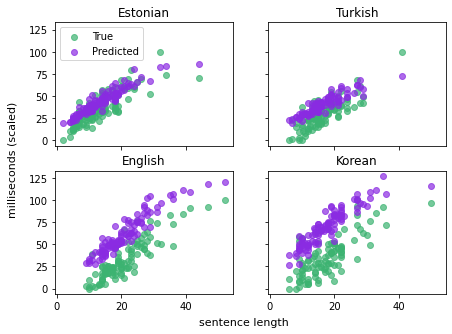

In [20]:
languages = ['Estonian', 'Turkish', 'English','Korean']
true_pred_df_1 = get_true_pred_df(get_meco_df(languages[0]))
true_pred_df_2 = get_true_pred_df(get_meco_df(languages[1]))
true_pred_df_3 = get_true_pred_df(get_meco_df(languages[2]))
true_pred_df_4 = get_true_pred_df(get_meco_df(languages[3]))

print(true_pred_df_2)

colors = ['blueviolet', 'mediumseagreen']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(7,5))

x = true_pred_df_1['sent_length']
y_true = true_pred_df_1['true_value']
y_pred = true_pred_df_1['pred_value']
ax1.scatter(x,y_true,alpha=0.7,c=colors[1])
ax1.scatter(x,y_pred,alpha=0.7,c=colors[0])
ax1.set_title(languages[0])

x = true_pred_df_2['sent_length']
y_true = true_pred_df_2['true_value']
y_pred = true_pred_df_2['pred_value']
ax2.scatter(x,y_true,alpha=0.7,c=colors[1])
ax2.scatter(x,y_pred,alpha=0.7,c=colors[0])
ax2.set_title(languages[1])

x = true_pred_df_3['sent_length']
y_true = true_pred_df_3['true_value']
y_pred = true_pred_df_3['pred_value']
ax3.scatter(x,y_true,alpha=0.7,c=colors[1])
ax3.scatter(x,y_pred,alpha=0.7,c=colors[0])
ax3.set_title(languages[2])

x = true_pred_df_4['sent_length']
y_true = true_pred_df_4['true_value']
y_pred = true_pred_df_4['pred_value']
ax4.scatter(x,y_true,alpha=0.7,c=colors[1])
ax4.scatter(x,y_pred,alpha=0.7,c=colors[0])
ax4.set_title(languages[3])
ax1.legend(['True', 'Predicted'], loc='upper left', fontsize=10)

fig.text(0.5, 0.04, 'sentence length', ha='center', fontsize=11)
fig.text(0.03, 0.5, 'milliseconds (scaled)', va='center', rotation='vertical',fontsize=11)

#plt.savefig('preds_4_languages.pdf',dpi=300, bbox_inches='tight')

KeyError: 'avg_token_freq'

<Figure size 432x288 with 0 Axes>

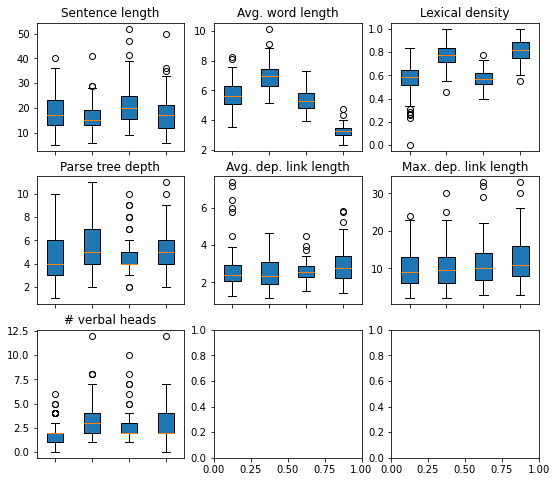

In [92]:
import matplotlib.pyplot as plt

fig = plt.figure()

fig, ((ax1, ax2, ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(9,8))
#fig, ((ax1, ax2, ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(7.5,5))

languages = ['Norwegian', 'Turkish', 'English','Korean']
dataset_1 = get_meco_df(languages[0])
dataset_2 = get_meco_df(languages[1])
dataset_3 = get_meco_df(languages[2])
dataset_4 = get_meco_df(languages[3])

# rectangular box plot
bplot1 = ax1.boxplot([dataset_1['token_count'].tolist(), dataset_2['token_count'].tolist(), dataset_3['token_count'].tolist(), dataset_4['token_count'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['','','',''],
                     showfliers=True)
ax1.set_title('Sentence length')

bplot2 = ax2.boxplot([dataset_1['avg_word_length'].tolist(), dataset_2['avg_word_length'].tolist(), dataset_3['avg_word_length'].tolist(), dataset_4['avg_word_length'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['','','',''],
                     showfliers=True) 
ax2.set_title('Avg. word length')

bplot3 = ax3.boxplot([dataset_1['lexical_density'].tolist(), dataset_2['lexical_density'].tolist(), dataset_3['lexical_density'].tolist(), dataset_4['lexical_density'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['','','',''],
                     showfliers=True)  # will be used to label x-ticks
ax3.set_title('Lexical density')

bplot4 = ax4.boxplot([dataset_1['avg_max_depth'].tolist(), dataset_2['avg_max_depth'].tolist(), dataset_3['avg_max_depth'].tolist(), dataset_4['avg_max_depth'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['','','',''],
                     showfliers=True)  # will be used to label x-ticks
ax4.set_title('Parse tree depth')

bplot5 = ax5.boxplot([dataset_1['avg_links_len'].tolist(), dataset_2['avg_links_len'].tolist(), dataset_3['avg_links_len'].tolist(), dataset_4['avg_links_len'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['','','',''],
                     showfliers=True)  # will be used to label x-ticks
ax5.set_title('Avg. dep. link length')


bplot6 = ax6.boxplot([dataset_1['max_links_len'].tolist(), dataset_2['max_links_len'].tolist(), dataset_3['max_links_len'].tolist(), dataset_4['max_links_len'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['','','',''],
                     showfliers=True)  # will be used to label x-ticks
ax6.set_title('Max. dep. link length')

bplot7 = ax7.boxplot([dataset_1['verbal_head_per_sent'].tolist(), dataset_2['verbal_head_per_sent'].tolist(), dataset_3['verbal_head_per_sent'].tolist(), dataset_4['verbal_head_per_sent'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['','','',''],
                     showfliers=True)  # will be used to label x-ticks
ax7.set_title('# verbal heads')

bplot8 = ax8.boxplot([dataset_1['avg_token_freq'].tolist(), dataset_2['avg_token_freq'].tolist(), dataset_3['avg_token_freq'].tolist(), dataset_4['avg_token_freq'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['','','',''],
                     showfliers=True)  # will be used to label x-ticks
ax8.set_title('Avg. word freq.')

bplot9 = ax9.boxplot([dataset_1['n_low_freq_words'].tolist(), dataset_2['n_low_freq_words'].tolist(), dataset_3['n_low_freq_words'].tolist(), dataset_4['n_low_freq_words'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['','','',''],
                     showfliers=True)  # will be used to label x-ticks
ax9.set_title('# low freq. words')

# fill with colors
colors = ['#1b9e77', 'lightgreen', 'lightblue', '#7570b3']
for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
#for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)

for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
#for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6):
    for patch, color in zip(bplot['fliers'], colors):
        patch.set_markeredgecolor(color)
        patch.set_alpha(0.5)
        
colors = ['#b2df8a', 'green', 'blue', 'lightblue']
for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
#for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6):
    for patch, color in zip(bplot['medians'], colors):
        patch.set_color(color)
        
colors = ['#1b9e77', '#1b9e77', 'lightgreen', 'lightgreen', 'lightblue', 'lightblue', '#7570b3', '#7570b3']
for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
#for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6):
    for patch, color in zip(bplot['whiskers'], colors):
        patch.set_color(color)

for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
#for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6):
    for patch, color in zip(bplot['caps'], colors):
        patch.set_color(color)
        
ax8.legend([bplot1["boxes"][0], bplot1["boxes"][1], bplot1["boxes"][2], bplot1["boxes"][3]], languages, loc='upper left', prop={'size': 11}, ncol=4, bbox_to_anchor=(-0.75, -0.03))
        
#plt.savefig('crosslingual-complexity.pdf', dpi=300, bbox_inches='tight')

Text(0.06, 0.5, 'milliseconds (scaled)')

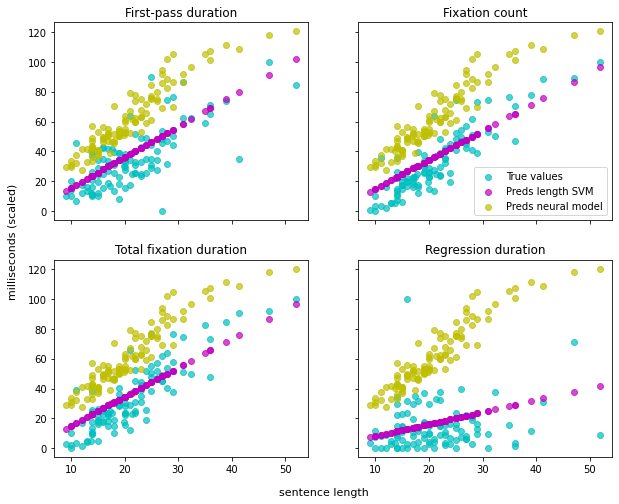

In [77]:
# 4 eye-tracking metrics vs. 1 SVM

svm_type = 'length'
language = 'English'
preds_neural = get_true_pred_df(get_meco_df(language))
x = preds_neural['sent_length']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,8))

title_dict = {'first_pass_dur': 'First-pass duration',
              'fix_count': 'Fixation count',
              'tot_fix_dur': 'Total fixation duration',
              'tot_regr_from_dur': 'Regression duration'}

for et_metric, ax in zip(['first_pass_dur', 'fix_count', 'tot_fix_dur', 'tot_regr_from_dur'], [ax1, ax2, ax3, ax4]):
    preds_svm = pd.read_csv(f'../results/preds-{svm_type}-svm-scaled_{et_metric}-{language}.tsv', sep='\t', names=['et-feature', 'pred_value', 'true_value'])
    y_true = preds_svm['true_value']
    y_svm = preds_svm['pred_value']
    y_neural = preds_neural['pred_value']
    ax.scatter(x,y_true,alpha=0.7,c='c')
    ax.scatter(x,y_svm,alpha=0.7,c='m')
    ax.scatter(x,y_neural,alpha=0.7,c='y')
    ax.set_title(title_dict[et_metric])

ax2.legend(['True values', f'Preds {svm_type} SVM', 'Preds neural model'], loc='lower right')

fig.text(0.5, 0.06, 'sentence length', ha='center', fontsize=11)
fig.text(0.06, 0.5, 'milliseconds (scaled)', va='center', rotation='vertical',fontsize=11)

Text(0.06, 0.5, 'milliseconds (scaled)')

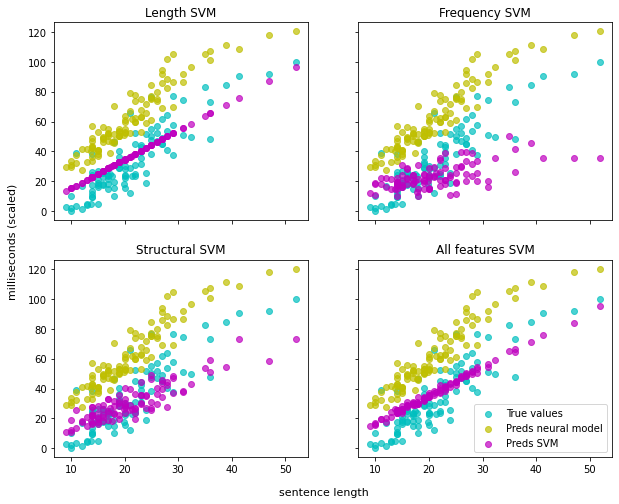

In [78]:
# 4 SVMs vs 1 eye-tracking metric

et_metric = 'tot_fix_dur'
language = 'English'
preds_neural = get_true_pred_df(get_meco_df(language))
x = preds_neural['sent_length']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,8))

title_dict = {'length': 'Length SVM',
              'frequency': 'Frequency SVM',
              'linguistic': 'Structural SVM',
              'all': 'All features SVM'}

for svm_type, ax in zip(['length', 'frequency', 'linguistic', 'all'], [ax1, ax2, ax3, ax4]):
    preds_svm = pd.read_csv(f'../results/preds-{svm_type}-svm-scaled_{et_metric}-{language}.tsv', sep='\t', names=['et-feature', 'pred_value', 'true_value'])
    y_true = preds_svm['true_value']
    y_neural = preds_neural['pred_value']
    y_svm = preds_svm['pred_value']
    ax.scatter(x,y_true,alpha=0.7,c='c')
    ax.scatter(x,y_neural,alpha=0.7,c='y')
    ax.scatter(x,y_svm,alpha=0.7,c='m')
    ax.set_title(title_dict[svm_type])

ax4.legend(['True values', f'Preds neural model', 'Preds SVM'], loc='lower right')
fig.text(0.5, 0.06, 'sentence length', ha='center', fontsize=11)
fig.text(0.06, 0.5, 'milliseconds (scaled)', va='center', rotation='vertical',fontsize=11)

In [187]:
from sklearn.metrics import mutual_info_score, explained_variance_score, r2_score
from scipy.stats import ks_2samp
import scipy

for language in ['English']:
    print(language)
    preds_neural = get_true_pred_df(get_meco_df(language))
    print(preds_neural.head())
    #preds_svm = pd.read_csv(f'../results/preds-{svm_type}-svm-scaled_tot_fix_dur-English.tsv', sep='\t', names=['et-feature', 'pred_value', 'true_value'])
    y_true = preds_neural['true_value']
    y_neural = preds_neural['pred_value']
    y_scrambled = preds_neural['pred_value_scrambled']
    #y_svm = preds_svm['pred_value']
#     print(ks_2samp(y_true, y_neural, mode='exact'))
#     print(ks_2samp(y_true, y_svm, mode='exact'))
    print(explained_variance_score(y_true, y_neural)), print(r2_score(y_true, y_neural))
    print(explained_variance_score(y_true, y_scrambled)), print(r2_score(y_true, y_scrambled))
#     print(explained_variance_score(y_true, y_svm))
    #print(explained_variance_score(y_true, len(y_true) * [21.53]))

English
  lang  trialid  sentnum                                           sentence  \
0   en        1        1  In ancient Roman religion and myth, Janus is t...   
1   en        1        2  He has a double nature and is usually depicted...   
2   en        1        3  Janus presided over the beginning and ending o...   
3   en        1        4  The doors of his temple were open in times of ...   
4   en        1        5  As the god of gates, he was also associated wi...   

   true_value  pred_value  pred_value_scrambled  sent_length  
0   38.531011   42.963680             47.654630    14.000000  
1   42.628949   53.237656             61.409985    23.000000  
2   24.345367   36.584538             43.701775    14.000000  
3   16.195266   41.025185             46.902650    15.000000  
4   24.788092   38.837578             40.995910    17.342105  
0.7630181752769337
-0.8194506955219301
0.6610016907233478
-1.7272708925965143
